## ML MIPT Practical 3

Потапова Софья, 394 группа

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

-------
#### Знакомство с данными

In [2]:
data = pd.read_csv('train.csv', index_col=0, na_values='NaN')
print(data.shape)
print(data.head())

(352278, 2)
                                          Reviews_Summary  Prediction
ID                                                                   
230872                                  Babies love these           3
344823                                       Salmon Trout           0
211754                                     disappointment           1
259421  Doesn't taste like Cinnabon; tastes like Waffl...           2
253418  Delicious San Daniele prosciutto and good cust...           3


In [3]:
documents = data.Reviews_Summary.values
score = data.Prediction.values

Каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку, по тексту отзыва.

-----
### 1. Извлечение признаков - 10 Баллов
 

1. Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Используйте n_features = 3000

In [1]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=300)
sparse_data = hv.transform(documents)

NameError: name 'documents' is not defined

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Напишите код, принимающий на вход разреженную матрицу векторного представления документов и возвращающий разреженную матрицу документов, частоты термов которых взвешенны по TF-IDF.

Дополнительная информация для решения задачи:

- Подробнее про TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- Используйте трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(sparse_data)

------

### 2. Код для SVM и логистической регресии - 40 Баллов

После того, как вы получили матрицу признаков, вам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделей будет использоваться стохастический градиентный спуск.

Дополнительная информация для решения задачи:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM стартовый код находится в файле cs231n/classifiers/linear_svm.py вашей задачей является реализация подсчета функции потерь для SVM

Разбейте обучающую выборку на 2 части train и test

Дополнительная информация для решения задачи:
- Используйте трансформер: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split

In [6]:
from scipy import sparse
data_train = sparse.hstack([tfidf, np.ones((tfidf.shape[0], 1))])

In [9]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [8]:
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(data_train, score)

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM

In [198]:
X_train = X_train.transpose()
X_test = X_test.transpose()

Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [199]:
X_train_sample = X_train[:, 0:100000]
y_train_sample = y_train[0:100000]

Найдем чему равен градиент:

In [11]:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print(loss, grad)

2.94213294957 [[ -1.29922670e-04   3.14103719e-04   1.16076611e-05 ...,   6.32690412e-04
   -2.15337428e-05   5.94720000e-01]
 [ -7.73784015e-05   1.96445960e-04   8.33045626e-05 ...,   8.80214835e-04
    6.55096814e-05   7.73720000e-01]
 [ -2.79967931e-05   4.11847359e-05  -6.26406637e-05 ...,   4.61481089e-04
    1.15093636e-05   3.86360000e-01]
 [  2.34928132e-04  -5.50943299e-04  -3.25965611e-05 ...,  -1.97403283e-03
   -5.56357302e-05  -1.75480000e+00]]


In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000112 analytic: -0.000112, relative error: 1.639756e-07
numerical: 0.001730 analytic: 0.001730, relative error: 1.652796e-08
numerical: 0.000832 analytic: 0.000832, relative error: 3.308509e-08
numerical: 0.003243 analytic: 0.003243, relative error: 5.830914e-08
numerical: -0.000113 analytic: -0.000113, relative error: 7.991325e-07


Теперь реализуйте векторизованную версию расчета фунции потерь - svm_loss_vectorized

In [13]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.942133e+00 computed in 44.773178s
Vectorized loss: 2.942133e+00 computed in 7.692690s
difference: 0.000000


Завершите реализацию SVM, реализуйте векторизированную версию расчета градиента.

In [14]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized
loss, grad = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.0)

from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000160 analytic: 0.000160, relative error: 6.872307e-08
numerical: -0.000066 analytic: -0.000066, relative error: 7.811180e-08
numerical: -0.000028 analytic: -0.000028, relative error: 1.118474e-06
numerical: -0.000216 analytic: -0.000216, relative error: 7.675765e-08
numerical: 0.001278 analytic: 0.001278, relative error: 4.769249e-09


In [15]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 41.168456s
Vectorized loss and gradient: computed in 5.139300s
difference: 0.000000


### Stochastic Gradient Descent

In [16]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

That took 469.325405s
Current loss is 5.646963


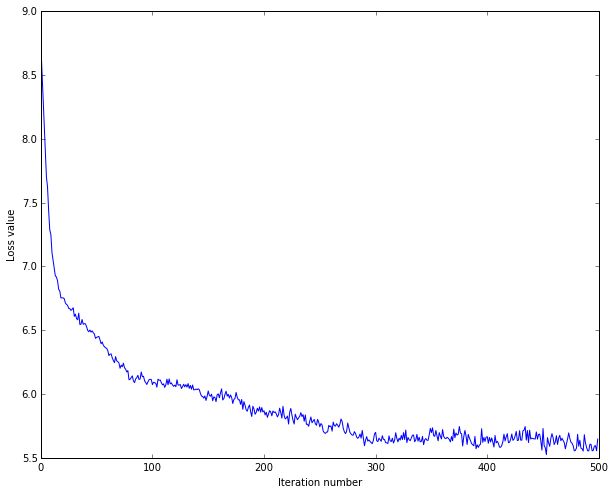

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [57]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

In [58]:
y_test_pred

array([3, 3, 3, ..., 3, 3, 3])

In [56]:
y_test

array([3, 3, 3, ..., 2, 3, 3])

In [27]:
#and evaluate the performance on both the test set
from sklearn.metrics import classification_report

In [59]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      8811
          1       0.00      0.00      0.00      4949
          2       0.00      0.00      0.00     13474
          3       0.69      1.00      0.82     60836

avg / total       0.48      0.69      0.56     88070



/home/d_k/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
# compare result with the most common dummy classifier
print(classification_report(y_test, [3]*len(y_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      8811
          1       0.00      0.00      0.00      4949
          2       0.00      0.00      0.00     13474
          3       0.69      1.00      0.82     60836

avg / total       0.48      0.69      0.56     88070



/home/d_k/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------

## Softmax Classifier

In [202]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1.379753
sanity check: 2.302585


In [203]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
#loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000091 analytic: -0.000091, relative error: 1.341662e-07
numerical: 0.000065 analytic: 0.000065, relative error: 1.527691e-07
numerical: 0.000042 analytic: 0.000042, relative error: 4.039591e-08
numerical: -0.000014 analytic: -0.000014, relative error: 8.316645e-07
numerical: 0.000158 analytic: 0.000158, relative error: 6.141128e-08


In [205]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from cs231n.classifiers.softmax import softmax_loss_naive
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print( 'Gradient difference: %f' % grad_difference)

naive loss: 1.379765e+00 computed in 94.195066s
vectorized loss: 1.379765e+00 computed in 0.065194s
Loss difference: 0.000000
Gradient difference: 0.000000


In [76]:
from cs231n.classifiers import Softmax
sm = Softmax()
tic = time.time()
#loss_hist = sm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
 #                     num_iters=500, verbose=True, batch_size=20000)
loss_hist = sm.train(X_train, y_train)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

That took 1.946114s
Current loss is 1.117872


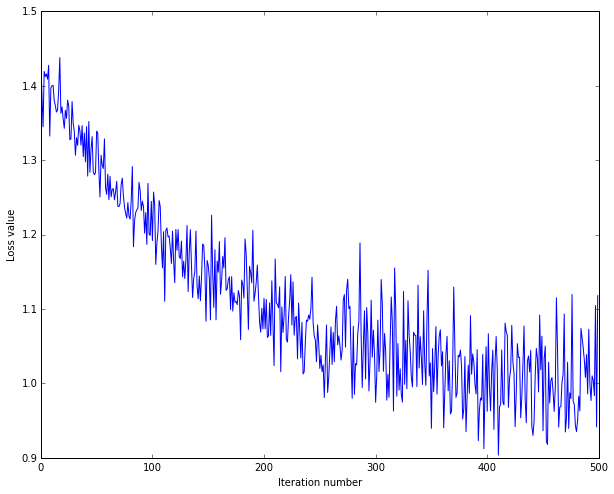

In [77]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [72]:
# Write the LinearSVM.predict function 
y_train_pred = sm.predict(X_train)
y_test_pred = sm.predict(X_test)

In [73]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      8811
          1       0.00      0.00      0.00      4949
          2       0.00      0.00      0.00     13474
          3       0.69      1.00      0.82     60836

avg / total       0.48      0.69      0.56     88070



/home/d_k/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
# compare result with the most common dummy classifier
print(classification_report(y_test, [3]*len(y_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      8811
          1       0.00      0.00      0.00      4949
          2       0.00      0.00      0.00     13474
          3       0.69      1.00      0.82     60836

avg / total       0.48      0.69      0.56     88070



/home/d_k/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Parameter selection

In [108]:
from sklearn.metrics import log_loss

In [126]:
def get_probs(x):
    res = (x - min(x))
    return res / sum(res)

def param_select(clf, X, y):
    #clf = Softmax()
    

In [140]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
scores = []
for lr in learning_rates:
    clf = Softmax()
    clf.train(X_train, y_train, learning_rate=lr)
    y_pred = clf.predict(X_test)
    y_out = np.apply_along_axis(get_probs, 1, y_pred)
    scores.append(log_loss(y_test, y_out.T))
    

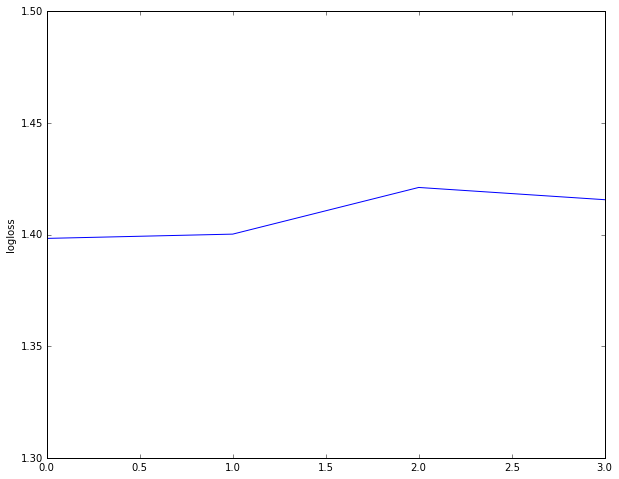

In [143]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.ylabel('logloss')
plt.ylim([1.3, 1.5])
plt.show()

In [144]:
batch_sizes = [200, 300, 400, 500]
scores = []
for b in batch_sizes:
    clf = Softmax()
    clf.train(X_train, y_train, batch_size=b)
    y_pred = clf.predict(X_test)
    y_out = np.apply_along_axis(get_probs, 1, y_pred)
    scores.append(log_loss(y_test, y_out.T))
    

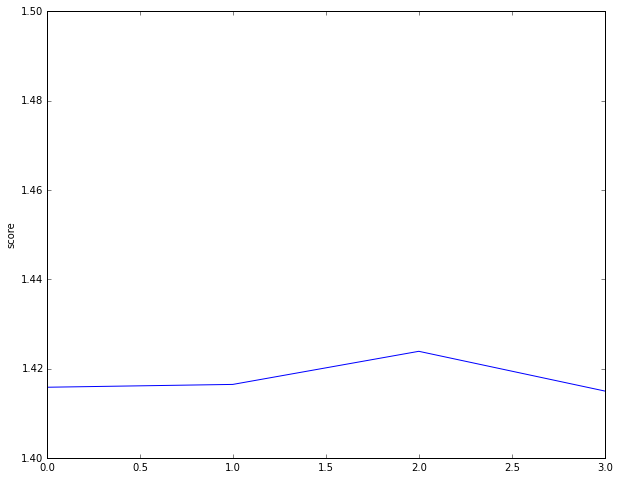

In [138]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.ylabel('logloss')
plt.ylim([1.4, 1.5])
plt.show()

In [148]:
nums_iters = [100, 200, 300, 400, 500, 1000, 10000]
scores = []
for it in nums_iters:
    clf = Softmax()
    clf.train(X_train, y_train, num_iters=it)
    y_pred = clf.predict(X_test)
    y_out = np.apply_along_axis(get_probs, 1, y_pred)
    scores.append(log_loss(y_test, y_out.T))
    

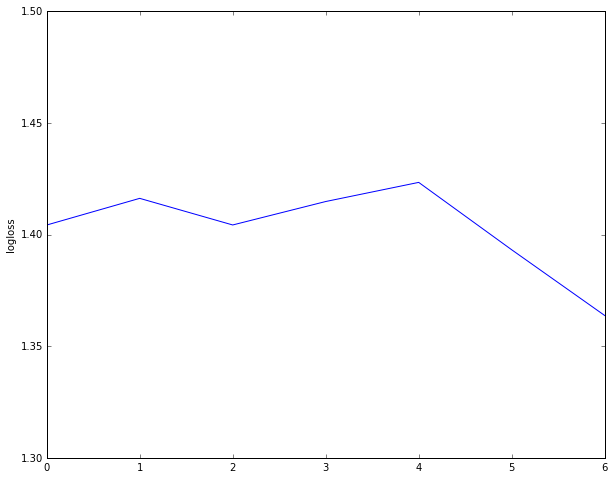

In [149]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.ylabel('logloss')
plt.ylim([1.3, 1.5])
plt.show()

------

### 3. Kaggle In Class - 50 Баллов

Используйте полученные модели для решения контеста. Выберете одну из моделей, реализуйте настройку гиперпараметров и пайплайн для предсказания классов тестовой выборки для сабмита в систему.

In [40]:
data_test = pd.read_csv('test.csv', index_col=0, na_values='NaN')
documents = data_test.Reviews_Summary.values
indices = data_test.index

In [186]:
hv = HashingVectorizer(n_features=3000)
data_test_hv = hv.transform(documents)
data_test = transformer.fit_transform(data_test_hv)

In [42]:
data_test = sparse.hstack([data_test, np.ones((data_test.shape[0], 1))])

In [43]:
data_test = data_test.T

In [175]:
W = np.random.randn(4, 3000) * 10
clf = Softmax()
loss_hist = clf.train(sparse.csc_matrix(data_train.T), score, learning_rate=1e-1, reg=1e-4, num_iters=500, batch_size=400)
y_pred = clf.predict(data_test)

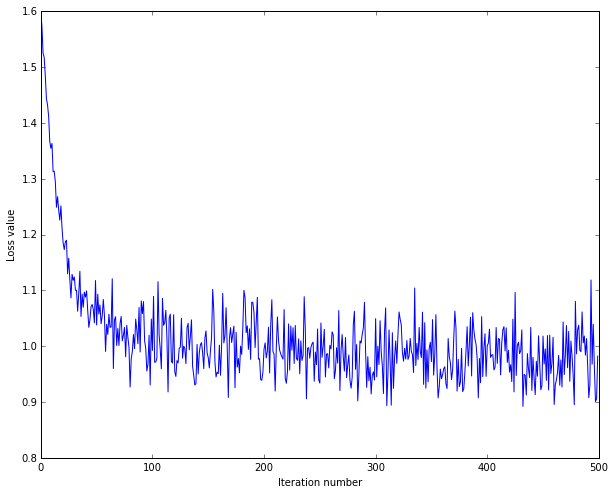

In [170]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [181]:
res = np.argmax(y_pred, axis=0).T

In [67]:
np.count_nonzero(y_pred == 0), np.count_nonzero(y_pred == 1), np.count_nonzero(y_pred == 2), np.count_nonzero(y_pred == 3)

(2110, 33776, 13361, 124264)


In [ ]:
pd.DataFrame(res, index=indices,
     columns=['class_0', 'class_1', 'class_2', 'class_3']).to_csv('result_svm.csv')

------

### 4. Бонусы - 30 Баллов

Улучшите результат: 

- Нормализуйте слова в документах, используйте стоп слова, попробуйте различные стратегии нормализации в TF-IDF
- Используйте PCA, Word2Vec для расширения пространства фичей
- Придумайте другие стратегии и улучшайте свой результат

К сожалению, не получилось реализовать ни то, ни другое - не хватило вычислительных мощностей компа, а аккаунт на амазоне еще не завела. Оставляю код, чтоб Вы видели, что я пыталась

### Word2Vec

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec.load_word2vec_format('/word2vec_dir/GoogleNews-vectors-negative300.bin', binary=True)

In [229]:
data = pd.read_csv('train.csv', index_col=0, na_values='NaN')
documents = data.Reviews_Summary.values
score = data.Prediction.values

In [231]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
def review_wordlist(review, remove_stopwords=True):
    #remove HTML
    text = review #bs(review, "lxml").get_text()
    words = tknzr.tokenize(text)
    words = [s for s in words if str.isalpha(s)]
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        stops.update(set(stopwords.words('russian')))
        words = [s for s in words if not s in stops]
    return words

In [232]:
def summary2vec(summary):
    tokens = review_wordlist(summary)
    vec = [model[token.lower()] for token in tokens if token.lower() in model]
    if len(vec) != 0:
        return sum(vec) / len(vec)
    return [0 for i in range(300)]

In [ ]:
data_train = [summary2vec(doc) for doc in documents]

### PCA

In [228]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3000)
data_train = data_train.toarray()
pca.fit(data_train)
data_train = pca.transform(data_train)


MemoryError: 